[View in Colaboratory](https://colab.research.google.com/github/riklmr/happy_whales/blob/master/siamese_whales_group_X_gray.ipynb)

### imports and installs

In [0]:
!pip install -U -q kaggle
!pip install -U -q PyDrive


In [2]:
import glob
import pandas as pd
import numpy as np
import cv2
import io, os

from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
from google.colab import files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

import keras
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
# import numpy.random as rng
# import numpy as np
# import os
# import dill as pickle

import matplotlib.pyplot as plt
# from sklearn.utils import shuffle



Using TensorFlow backend.


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
file_W = "siamese_whale_cnn.hdf5"   # siamese_convnet.hdf5


### API Credentials for Kaggle
To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com//account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials.
Place this file on your Google Drive anywhere.
With the next snippet you download your credentials to Colab and you can start using Kaggle API

In [5]:
drive_service = build('drive', 'v3')
results = drive_service.files().list( q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

! ls -l .kaggle/kaggle.json

Download 100%.
---x-wx--T 1 root root 66 Apr  3 06:52 .kaggle/kaggle.json


In [6]:
! ls -ltra /content


total 44
drwxr-xr-x 1 root root 4096 Apr  3 06:49 ..
-rw------- 1 root root 1024 Apr  3 06:50 .rnd
drwxr-xr-x 4 root root 4096 Apr  3 06:50 .forever
drwx------ 3 root root 4096 Apr  3 06:50 .local
drwxr-xr-x 5 root root 4096 Apr  3 06:50 .ipython
drwxr-xr-x 3 root root 4096 Apr  3 06:50 .config
drwx------ 4 root root 4096 Apr  3 06:50 .cache
drwxr-xr-x 2 root root 4096 Apr  3 06:51 .keras
drwxr-xr-x 1 root root 4096 Apr  3 06:51 datalab
drwxr-xr-x 1 root root 4096 Apr  3 06:52 .
drwxr-xr-x 2 root root 4096 Apr  3 06:52 .kaggle


In [7]:
# ! sleep 20 # really ?!?!
!kaggle competitions list


ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
imagenet-object-detection-challenge             2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-detection-from-video-challenge  2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-localization-challenge          2029-12-31 07:00:00  Research         Knowledge          5           False  
titanic                                         2020-04-07 00:00:00  Getting Started  Knowledge      10603           False  
house-prices-advanced-regression-techniques     2020-03-01 23:59:00  Getting Started  Knowledge       4563           False  
digit-recognizer                                2020-01-07 00:00:00  Getting Started  Knowledge       2086           False  


In [0]:
TRAINPATH = "whale-dataset/train/"
TRAINPREPPATH = "whale-prep/train/"
TESTPATH = "whale-dataset/test/"
TESTPREPPATH = "whale-prep/test/"

In [0]:
!mkdir -p whale-dataset/
!mkdir -p whale-prep/test
!mkdir -p whale-prep/train


In [10]:
! ls -d whale*/t*/ whale-dataset


whale-dataset  whale-prep/test/  whale-prep/train/


In [11]:
!kaggle competitions download -c whale-categorization-playground -p whale-dataset 

sample_submission.csv: Downloaded 960KB of 960KB
train.csv: Downloaded 221KB of 221KB
test.zip: Downloaded 405MB of 405MB
train.zip: Downloaded 260MB of 260MB


In [12]:
! ls whale-dataset


sample_submission.csv  test.zip  train.csv  train.zip


In [0]:
! cd whale-dataset; unzip -q -o test.zip ; unzip -q -o train.zip

In [14]:
! du -sh whale-dataset/*

964K	whale-dataset/sample_submission.csv
453M	whale-dataset/test
406M	whale-dataset/test.zip
290M	whale-dataset/train
224K	whale-dataset/train.csv
260M	whale-dataset/train.zip


In [0]:
# ! git clone https://github.com/riklmr/happy_whales --quiet
# ! cd happy_whales ; git pull --quiet

### retrieve saved model from google drive


In [22]:
file_list = drive.ListFile({'q': "'root' in parents and trashed=false" }).GetList()

for file1 in file_list:
    if file1['title'] == file_W:
        file_id_W = file1['id']
#
print("downloading file name wih id", file_W, file_id_W)
downloaded = drive.CreateFile({'id': file_id_W})
downloaded.GetContentFile(file_W)

downloading file name wih id siamese_whale_cnn.hdf5 1M-XHFyf4XC4BwY87GEPE302T6BinFt-8


In [23]:
! ls -l {file_W}

-rw-r--r-- 1 root root 21828152 Apr  3 06:54 siamese_whale_cnn.hdf5


## example Siamese convnet taken from Soren Bouma (siamese_net)
[Soren's blog](https://sorenbouma.github.io/blog/oneshot/)

[Soren's notebook](https://github.com/sorenbouma/keras-oneshot/blob/master/SiameseNet.ipynb)


[Paper](http://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) referenced by Bouma: 

KOCH, Gregory; ZEMEL, Richard; SALAKHUTDINOV, Ruslan. Siamese neural networks for one-shot image recognition. In: ICML Deep Learning Workshop. 2015.

In [0]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = np.random.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=np.random.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)



In [0]:
# input_shape = (105, 105, 1)
input_shape = (335, 1005, 1)



In [26]:
# each "leg" has its own input layer
left_input = Input(input_shape, name='left_input')
right_input = Input(input_shape, name='right_input')

#build one common convnet to use in each siamese 'leg'

# as designed by Bouma:
# input has size          105x105x1
#  Conv2D(64,(10,10)   #   64x96x96
#   MaxPooling2D       #   64x48x48
#  Conv2D(128,(7,7)    #  128x42x42
#   MaxPooling2D       #  128x21x21
#  Conv2D(128,(4,4)    #  128x18x18
#   MaxPooling2D       #  128x 9x 9
#  Conv2D(256,(4,4)    #  256x 6x 6
#   Flatten            # 4096x1
#  Dense(4096)         # 4096x1 as output (this is the feature vector for an image)
# has about 39M parameters

# A note about this convnet (by Rik): it starts with a maxpooling to reduce the
# size of the input from 335x1005 to 1/2 of that: 167x502
# this is followed by a conv2d with unusual assymetric stride (1,3)
# this further reduces the size of the "feature map" to an almost square shape.
# I further reduced the size of the convnet to fit a smaller computer, by asking for fewer and smaller feature maps
# the final feauture map flattens to 1920 units
# which I further reduce to 768 units to keep the number of trainable parameters under 2M
convnet = Sequential(name='convnet')
convnet.add(MaxPooling2D(input_shape=input_shape))
convnet.add(Conv2D(48,(10,10), strides=(1,3), activation='relu',input_shape=input_shape, kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(48,(7,7), activation='relu', kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D(2,4))
convnet.add(Conv2D(96,(4,4), activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(96,(4,4), activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(768,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

#merge two encoded inputs with the L1 distance between them
# I followed Bouma's example here, I am not sure why he did not go with L2
L1_distance = lambda x: K.abs(x[0]-x[1])

both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0], name='merge')

prediction = Dense(1,activation='sigmoid',bias_initializer=b_init, name='prediction')(both)

siamese_net = Model(inputs=[left_input,right_input], outputs=prediction, name='siamese_net')
#optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paper working
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


1815265

In [27]:
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 167, 502, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 158, 165, 48)      4848      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 79, 82, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 73, 76, 48)        112944    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 19, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 16, 96)        73824     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 8, 96)          0         
__________

In [28]:
siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         (None, 335, 1005, 1) 0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        (None, 335, 1005, 1) 0                                            
__________________________________________________________________________________________________
convnet (Sequential)            (None, 768)          1814496     left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
merge (Merge)                   (None, 768)          0           convnet[1][0]                    
          

## data wrangling

In [0]:
train_df = pd.read_csv("whale-dataset/train.csv")
train_df["Image"] = train_df["Image"].map( lambda x : TRAINPATH+x)  # prepends path to filename in column "Image"

submit_df = pd.read_csv("whale-dataset/sample_submission.csv")
test_df = submit_df.copy()
test_df["Image"] = test_df["Image"].map( lambda x : TESTPATH+x)  # prepends path to filename in column "Image"
test_df.drop("Id", axis=1, inplace=True)


In [30]:
train_df.head()

,Image,Id
0,whale-dataset/train/00022e1a.jpg,w_e15442c
1,whale-dataset/train/000466c4.jpg,w_1287fbc
2,whale-dataset/train/00087b01.jpg,w_da2efe0
3,whale-dataset/train/001296d5.jpg,w_19e5482
4,whale-dataset/train/0014cfdf.jpg,w_f22f3e3


In [31]:
submit_df.head()

,Image,Id
0,00029b3a.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
1,0003c693.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
2,000bc353.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
3,0010a672.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
4,00119c3f.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46


In [32]:
test_df.head()


,Image
0,whale-dataset/test/00029b3a.jpg
1,whale-dataset/test/0003c693.jpg
2,whale-dataset/test/000bc353.jpg
3,whale-dataset/test/0010a672.jpg
4,whale-dataset/test/00119c3f.jpg


### functions for prepping images to our desired input shape
These two reshape_*whale() functions need to become one again, some day


In [0]:
def reshape_whale(bgr, target_shape):
    h,w,d = bgr.shape
    target_h, target_w, _ = target_shape

    tall = bgr
    if h<target_h:
        border_h = (target_h-h)//2
        tall=cv2.copyMakeBorder(bgr, top=border_h, bottom=border_h, left=0, right=0, borderType=cv2.BORDER_CONSTANT, value=(128, 128, 128) )
    #
    h,w,d = tall.shape
    wide = tall
    if w<target_w:
        wide = cv2.resize(tall, (0,0), fy=target_w/w, fx=target_w/w)
    #

    h,w,d = wide.shape
    whale = wide
    if h>target_h or w>target_w:
        whale = cv2.resize(wide, (target_w, target_h))

    return whale
#


In [0]:
def reshape_graywhale(gray, target_shape):
    target_h, target_w, _ = target_shape
    #
    h,w = gray.shape
    tall = gray
    if h<target_h:
        border_h = (target_h-h)//2
        tall=cv2.copyMakeBorder(gray, top=border_h, bottom=border_h, left=0, right=0, borderType=cv2.BORDER_CONSTANT, value=(255) )
    #
    h,w = tall.shape
    wide = tall
    if w<target_w:
        wide = cv2.resize(tall, (0,0), fy=target_w/w, fx=target_w/w)
    #
    h,w = wide.shape
    whale = wide
    if h>target_h or w>target_w:
        whale = cv2.resize(wide, (target_w, target_h))
    #
    return whale
#

### prep all images
train and test sets

reshape image and store in new files (when not yet done)

update dataframes

In [35]:
# train set prep
# turns out that two images do not load well (.reshape() fails)
# whale-prep/train/34042215.jpg
# whale-prep/train/374aaece.jpg
# reason unknown, we just exclude them from the list

which = train_df['Image'].isin([f"{TRAINPATH}34042215.jpg", f"{TRAINPATH}374aaece.jpg"])
train_df.drop(train_df.index[ which ], inplace=True)

m = len(train_df)
for i in range(m):
    fname, label = train_df.iloc[i].values
    prepname = fname.replace(TRAINPATH,TRAINPREPPATH, 1)
    if not os.path.isfile(prepname):
        bgr  = cv2.imread(fname)
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        whale = reshape_graywhale(gray, input_shape)
        cv2.imwrite(prepname, whale)
    train_df.iloc[i,0] = prepname
    if i%1000 == 0:
        print(i, m)
    #
print(i, m)




0 9848
1000 9848
2000 9848
3000 9848
4000 9848
5000 9848
6000 9848
7000 9848
8000 9848
9000 9848
9847 9848


In [36]:
# test set prep

m = len(test_df)
for i in range(m):
    fname, = test_df.iloc[i].values
    prepname = fname.replace(TESTPATH,TESTPREPPATH,1)
    if not os.path.isfile(prepname):
        bgr  = cv2.imread(fname)
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        whale = reshape_graywhale(gray, input_shape)
        cv2.imwrite(prepname, whale)
    test_df.iloc[i,0] = prepname
    if i%1000 == 0:
        print(i, m)
    #
print(i, m)


0 15610
1000 15610
2000 15610
3000 15610
4000 15610
5000 15610
6000 15610
7000 15610
8000 15610
9000 15610
10000 15610
11000 15610
12000 15610
13000 15610
14000 15610
15000 15610
15609 15610


### group images by whale Id
and then select pairs for training the siamese convnet


In [0]:
train_Id_groups = train_df.groupby(by='Id')


In [0]:
c=0
m = len(train_df)
max_train_size = int(m*5)
stats = []
train_siam = []


In [39]:
# pair each image with a twin from the same group by whale Id (wid)
for wid, whale_df in train_Id_groups:
    if wid == 'new_whale': 
        continue
    #
    whale_stats = 0
    whale_images = whale_df['Image'].values
    np.random.shuffle(whale_images)
    idx_images = len(whale_images) - 1
    while idx_images >0:
        # select the last two images from the shuffled group
        # keep updating the index into whale_images
        image_left  = whale_images[idx_images]
        idx_images -= 1
        image_right = whale_images[idx_images]
        idx_images -= 1
        # pair the 2 images with y=1 (same class)
        train_siam.append([image_left, image_right, 1])
        whale_stats += 1
        c+=1
        if c%500==0:
            print(c, max_train_size)
        if c>max_train_size: 
            break
        #
    #
    if idx_images == 0:
        # one image (left over) for this wid, let's pair it with itself
        image_left  = whale_images[0]
        image_right = whale_images[0]
        # pair the 2 images with y=1 (same class)
        train_siam.append([image_left, image_right, 1])
        whale_stats += 1
        c+=1
        if c%500==0:
            print(c, max_train_size)
        if c>max_train_size: 
            break
        #
    #
#


500 49240
1000 49240
1500 49240
2000 49240
2500 49240
3000 49240
3500 49240
4000 49240
4500 49240
5000 49240
5500 49240


In [40]:
# we now select pairs of images that arenever of the same whale by wid
# we create two half lists of the dataframe, one for left_image, one for right_image

# create two complementary lists of random numbers in range 0-m
# these numbers serve as indexes into train_df
left_numbers = np.random.choice(range(m), int(m/2), replace=False)
right_numbers = [x for x in range(m) if x not in left_numbers]
np.random.shuffle(left_numbers)
np.random.shuffle(right_numbers)
n = min(len(left_numbers), len(right_numbers))
print(len(left_numbers), len(right_numbers), n)

for i in range(n):
    # select two images with wids via the two shuffled index lists
    l = left_numbers[i]
    image_left  = train_df.iloc[l, 0]
    wid_left  = train_df.iloc[l, 1]

    j=i
    r = right_numbers[j]
    image_right = train_df.iloc[r, 0]
    wid_right = train_df.iloc[r, 1]
    
    # repeat the selection process on the right until right_image is no longer of the same whale by wid
    while wid_left == wid_right:
        print("you won't believe who I just saw in the sea!", i, j)
        j = (j + 1) % len(right_numbers) # just in case we run out of r's before l's, we wrap around (modulo) to the start of r's
        r = right_numbers[j]
        image_right = train_df.iloc[r, 0]
        wid_right = train_df.iloc[r, 1]

    # pair the 2 images with y=0 (different class)
    train_siam.append([image_left, image_right, 0])
    c+=1
    if c%500==0:
        print(c, max_train_size)
    if c>max_train_size: 
        break
    #
#


4924 4924 4924
6000 49240
you won't believe who I just saw in the sea! 197 197
you won't believe who I just saw in the sea! 251 251
you won't believe who I just saw in the sea! 390 390
you won't believe who I just saw in the sea! 407 407
6500 49240
you won't believe who I just saw in the sea! 571 571
you won't believe who I just saw in the sea! 571 572
you won't believe who I just saw in the sea! 584 584
you won't believe who I just saw in the sea! 790 790
you won't believe who I just saw in the sea! 790 791
you won't believe who I just saw in the sea! 953 953
7000 49240
you won't believe who I just saw in the sea! 1177 1177
you won't believe who I just saw in the sea! 1177 1178
you won't believe who I just saw in the sea! 1302 1302
you won't believe who I just saw in the sea! 1349 1349
you won't believe who I just saw in the sea! 1429 1429
7500 49240
you won't believe who I just saw in the sea! 1578 1578
you won't believe who I just saw in the sea! 1620 1620
you won't believe who I ju

In [54]:
def reshuffle_train(train_list):
    np.random.shuffle(train_siam)
    print(m, " rows reshuffled")
    return pd.DataFrame(data=train_list, columns=['image_left', 'image_right', 'same'])
#
train_siam_df = reshuffle_train(train_siam)
    

10896  rows reshuffled


In [43]:
train_siam_df['same'].sum() / len(train_siam_df)  # fraction of pairs with y=1 (same class in pair)

0.5480910425844346

In [45]:
len(train_siam_df)

10896

### browse a few images
And test the reshape function.

Thing to note: matplotlib wants RGB in order. CV2 gives them in reversed order BGR. The clever slicing ```bgr[:,:,::-1]``` takes care of that.

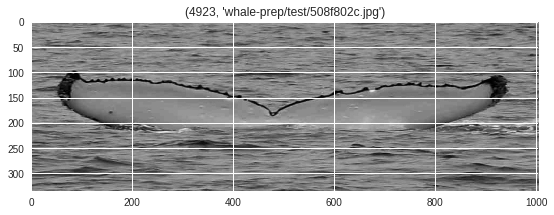

In [46]:
# i=15500
fname, = test_df.iloc[i].values
gray = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
fig = plt.figure(figsize=(20,10))
plt.subplot(221),plt.imshow(gray,    cmap='gray'),    plt.title((i, fname))
plt.show()
plt.close()
i = (i+1)%len(test_df)

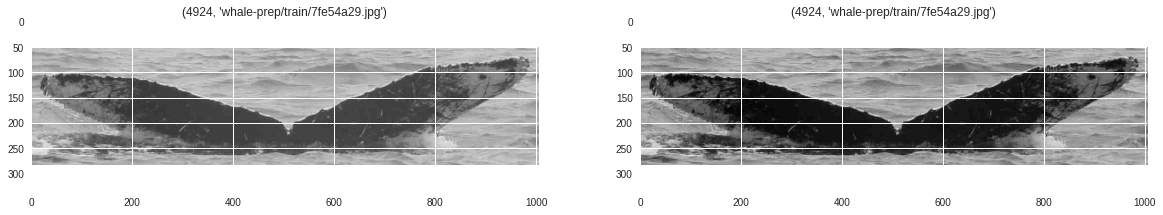

In [47]:
# CTRL-Enter this cell to your heart's content
fname, label = train_df.iloc[i].values

bgr = cv2.imread(fname)
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

# rgb = bgr[:,:,::-1] 

whale = reshape_graywhale(gray, input_shape)

prepname = fname.replace(TRAINPATH,TRAINPREPPATH)

fig = plt.figure(figsize=(20,10))
plt.subplot(221),plt.imshow(bgr[:,:,::-1],    cmap='gray'),    plt.title((i, fname))
plt.subplot(222),plt.imshow(whale,            cmap='gray'),    plt.title((i, prepname))
# plt.subplot(223),plt.imshow(rgb,    cmap='gray'),    plt.title('rgb'),    plt.xticks([]), plt.yticks([])
# plt.subplot(224),plt.imshow(gray,   cmap='gray'),   plt.title('gray'),   plt.xticks([]), plt.yticks([])
plt.show()
plt.close()
i = (i+1)%len(train_df)


# model training

### class by Bouma


In [0]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
#         self.data = {}
#         self.categories = {}
#         self.info = {}
        self.last_used = -1
        self.usable = len(train_siam_df)
        
#         for name in data_subsets:
#             file_path = os.path.join(path, name + ".pickle")
#             print("loading data from {}".format(file_path))
#             with open(file_path,"rb") as f:
#                 (X,c) = pickle.load(f)
#                 self.data[name] = X
#                 self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs"""
#         h=335
#         w=1005
        fname  = train_siam_df.iloc[0, 0]
        image  = np.array(cv2.imread(fname,  cv2.IMREAD_GRAYSCALE))
        (h,w) = image.shape

        pairs=[ np.zeros((batch_size, h, w, 1)) , np.zeros((batch_size, h, w, 1)) ]
        targets=np.zeros((batch_size,))
        
        if self.last_used + batch_size >= self.usable:
            self.last_used = -1
        #
        for i in range(batch_size):
            self.last_used += 1
            fname_left  = train_siam_df.iloc[self.last_used, 0]
            fname_right = train_siam_df.iloc[self.last_used, 1]
            target = train_siam_df.iloc[self.last_used, 2]

            # 335670
            # ValueError: cannot reshape array of size 335670 into shape (335,1005,1)
            image_left  = cv2.imread(fname_left,  cv2.IMREAD_GRAYSCALE)
            image_right = cv2.imread(fname_right, cv2.IMREAD_GRAYSCALE)
            try:
                pairs[0][i,:,:,:] = image_left.reshape(h, w, 1)
                pairs[1][i,:,:,:] = image_right.reshape(h, w, 1)
            except Exception as e:
                print("error 335670={}, h={}, w={}, image_left has shape {}, fname:{}".format(e, h,w,image_left.shape, fname_left))
            targets[i] = target
        #
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

#     def make_oneshot_task(self,N,s="val",language=None):
#         """Create pairs of test image, support set for testing N way one-shot learning. """
#         X=self.data[s]
#         n_classes, n_examples, w, h = X.shape
#         indices = rng.randint(0,n_examples,size=(N,))
#         if language is not None:
#             low, high = self.categories[s][language]
#             if N > high - low:
#                 raise ValueError("This language ({}) has less than {} letters".format(language, N))
#             categories = rng.choice(range(low,high),size=(N,),replace=False)
            
#         else:#if no language specified just pick a bunch of random letters
#             categories = rng.choice(range(n_classes),size=(N,),replace=False)            
#         true_category = categories[0]
#         ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
#         test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
#         support_set = X[categories,indices,:,:]
#         support_set[0,:,:] = X[true_category,ex2]
#         support_set = support_set.reshape(N, w, h,1)
#         targets = np.zeros((N,))
#         targets[0] = 1
#         targets, test_image, support_set = shuffle(targets, test_image, support_set)
#         pairs = [test_image,support_set]

#         return pairs, targets
    
#     def test_oneshot(self,model,N,k,s="val",verbose=0):
#         """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
#         n_correct = 0
#         if verbose:
#             print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
#         for i in range(k):
#             inputs, targets = self.make_oneshot_task(N,s)
#             probs = model.predict(inputs)
#             if np.argmax(probs) == np.argmax(targets):
#                 n_correct+=1
#         percent_correct = (100.0*n_correct / k)
#         if verbose:
#             print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
#         return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size), )
    
    
PATH="."
#Instantiate the class
loader = Siamese_Loader(PATH)


In [49]:
# test and debug loader
pairs, targets = loader.get_batch(15)
print(len(pairs))
print(len(pairs[0]))
print(len(pairs[0][0]))
print(len(pairs[0][0][0]))


2
15
335
1005


In [50]:
l = pairs[0][0]
l.shape

(335, 1005, 1)

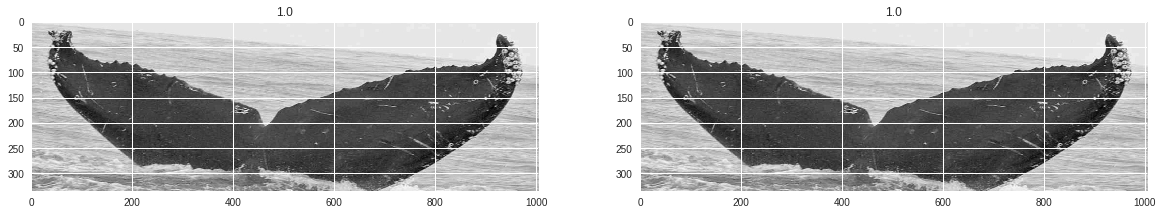

In [51]:
pairs, targets = loader.get_batch(1)
fig = plt.figure(figsize=(20,10))
plt.subplot(221),plt.imshow(pairs[0][0].reshape((335,1005)),   cmap='gray'),    plt.title(targets[0])
plt.subplot(222),plt.imshow(pairs[1][0].reshape((335,1005)),    cmap='gray'),    plt.title(targets[0])
plt.show()
plt.close()

In [52]:
! ls -l {file_W}

-rw-r--r-- 1 root root 21828152 Apr  3 06:54 siamese_whale_cnn.hdf5


## start training


In [55]:
# again, taken from bouma
# https://github.com/sorenbouma/keras-oneshot/blob/master/SiameseNet.ipynb

# siamese_net.save(file_W)
m = len(train_siam_df)
# evaluate_every = 70 # 7k
# loss_every=12 # 300
batch_size = 64 # 32
# N_way = 20
# n_val = 550
siamese_net.load_weights(file_W)
# best = 76.0
    
for go in range(2):
    uploaded = drive.CreateFile()
    uploaded.SetContentFile(file_W)
    train_siam_df = reshuffle_train(train_siam)
    epochs = 3
    siamese_net.fit_generator(loader.generate(batch_size),
                            epochs=epochs, 
                            steps_per_epoch=(m//batch_size),
                            callbacks = [keras.callbacks.ModelCheckpoint(file_W)]
                             )

    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))


# Bouma's training code:
# siamese_net.save(file_W)
# files.download(file_W)

# for i in range(900): # 9M
#     (inputs,targets)=loader.get_batch(batch_size)
#     loss=siamese_net.train_on_batch(inputs,targets)
#     if i % evaluate_every == 0:
# #         val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
# #         if val_acc >= best:
# #             print("saving")
#             siamese_net.save(file_W)
# #             best=val_acc

#     if i % loss_every == 0:
#         print("iteration {}, training loss: {:.2f},".format(i,loss))
        
        

10896  rows reshuffled
Epoch 1/3
170/170 [==============================] - 103s 606ms/step - loss: 0.0512
Epoch 2/3
170/170 [==============================] - 104s 611ms/step - loss: 0.0504
Epoch 3/3
170/170 [==============================] - 103s 604ms/step - loss: 0.0497
Uploaded file with ID 1uskoNLSVl-cHaI2txgNIQpPp7qFNEdy2
10896  rows reshuffled
Epoch 1/3
 13/170 [=>............................] - ETA: 1:39 - loss: 0.0493

170/170 [==============================] - 103s 604ms/step - loss: 0.0492
Epoch 2/3
170/170 [==============================] - 102s 599ms/step - loss: 0.0486
Epoch 3/3
170/170 [==============================] - 101s 596ms/step - loss: 0.0481
Uploaded file with ID 1svC1Q7xS_LscH2bxnjLZi-kzRhO_Ec8g


In [0]:
! ls -ltr

In [0]:
uploaded = drive.CreateFile()
uploaded.SetContentFile(file_W)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
